In [1]:
import librosa
import librosa.display
import numpy as np 
import glob
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import wavio
import IPython.display

import utils
import plot

/Users/oharasoh/study/bandai/venv/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/Users/oharasoh/study/bandai/venv/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [2]:
raw_specs, noised_specs = utils.load_spectrograms("../data")

In [3]:
raw_specs[2].shape

(128, 95)

In [135]:
input_dim = 128  # 128次元のメルスペクトログラム

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()


        self.conv1 = nn.Conv2d(1, 32, (5, 5), padding=(2, 2))
        self.act1 = nn.LeakyReLU()
        self.conv2 = nn.Conv2d(32, 32, (3,3), padding=1)
        self.act2 = nn.LeakyReLU()
        self.conv2_2 = nn.Conv2d(32, 32, (3,3), padding=1)
        self.act2_2 = nn.LeakyReLU()
        self.conv3 = nn.Conv2d(32, 1, (3, 3), padding=1)
        self.act3 = nn.Sigmoid()
        
    def forward(self, x):
        """
        Input:
        x (torch.Tensor): (N, input_dim).
        Output:
        y (torch.Tensor): (N, output_dim).
        """
        x = self.conv1(x)
        x = self.act1(x)
        res = self.conv2(x)
        x = self.act2(res)
        x = self.conv2_2(x)
        x = self.act2_2(x)
        x += res
        x = self.conv3(x)
        x = self.act3(x)
        return x
        

In [136]:
class Model(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=128, diff=1):
        """
        input_dim: 入力次元.128*3くらい
        hidden_dim: 隠れ次元情報としてどこまで圧縮するか
        output_dim: 出力次元。128で今回は固定
        ddof: 何次元まで差分をとっているか
        """
        super(Model, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim)
        self.decoder = Decoder(hidden_dim, output_dim)
        self.pad = nn.ReplicationPad2d((0, 0, diff, diff))
        self.diff = diff
        
        
    def forward(self, x, train=True):
        x = self.encoder(x)
        x = self.decoder(x)
        if not train:
            T = x.size()[0]  # length of time
            F = x.size()[1]  # num feature 
            x = x.view(1, 1, T, F)
            x = self.pad(x)
            x = x.view(T+self.diff*2, F)
        return x

In [137]:
class SpecDataset(Dataset):
    def __init__(self, specs):
        self.specs = specs
            
    
    def __len__(self):
        return len(self.specs)
    
    def __getitem__(self, idx):
        spec = self.specs[idx+1]
        spec = spec[np.newaxis, :, :]
        spec /= spec.max()
        return {"x": torch.Tensor(spec)}

In [138]:
model = Encoder()
train_dataset = SpecDataset(raw_specs)
test_dataset = SpecDataset(noised_specs)

In [139]:
spec = train_dataset[1]['x']
spec = spec.view(1, *spec.shape)
output = model(spec)

In [140]:
spec.shape, output.shape

(torch.Size([1, 1, 128, 95]), torch.Size([1, 1, 128, 95]))

In [161]:
lr = 1e-3
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [162]:
dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)

In [163]:
epochs = 5
name = "Conv2d"
loss_record  = []
test_loss_record = []
for epoch in range(epochs):
    train_idxs = np.arange(len(train_dataset))
    np.random.shuffle(train_idxs)
    test_idxs = np.arange(len(test_dataset))
    running_loss = 0.0
    for i, inputs in enumerate(dataloader):
        optimizer.zero_grad()
        outputs = model(inputs['x'])
        loss = criterion(outputs, inputs['x'])
        loss.backward()
        optimizer.step()
        loss_record.append(loss.item())
        running_loss += loss.item()
        
    print('[%d] train loss: %.3e' % (epoch+1, running_loss/len(train_idxs)))
    running_loss = 0.0
    eval_results = {}
    for i, idx in enumerate(test_idxs):
        inputs = test_dataset[idx]
        with torch.no_grad():
            x = inputs['x'].view(1, *inputs['x'].shape)
            outputs = model(x)
            loss = criterion(outputs, x)
        running_loss += loss.item()
        scale = noised_specs[idx+1].max()
        eval_results[idx+1] = outputs.cpu().numpy().reshape(*outputs.shape[2:])
        test_loss_record.append(loss.item())
    print('[%d] test loss: %.3e' % (epoch+1, running_loss/len(test_idxs)))
    save_dir = f"../out/{name}/{epoch:02d}"
    utils.save_specs(eval_results, save_dir=os.path.join(save_dir, "noised_tgt"))
    

[1] train loss: 6.799e-04
[1] test loss: 4.503e-04


KeyboardInterrupt: 

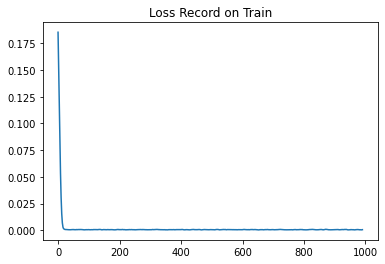

In [144]:
plt.title("Loss Record on Train")
plt.plot(np.convolve(loss_record, np.ones(10)/10.0, mode='valid'), label='train')


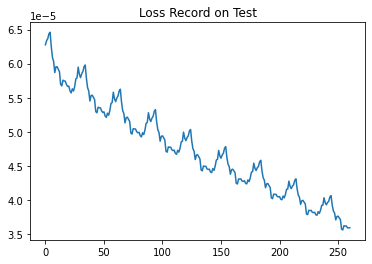

In [131]:
plt.title("Loss Record on Test")
plt.plot(np.convolve(test_loss_record, np.ones(40)/40.0, mode='valid'))

In [132]:
outputs.cpu().numpy().T.min()

9.630653e-05

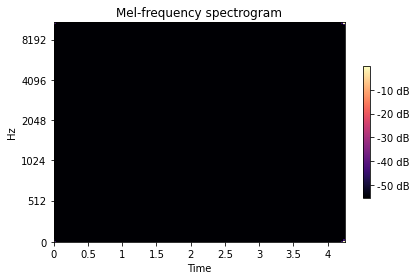

In [165]:
plot.plot_spectrogram(outputs.detach().cpu().numpy().reshape(outputs.shape[2:])*256)

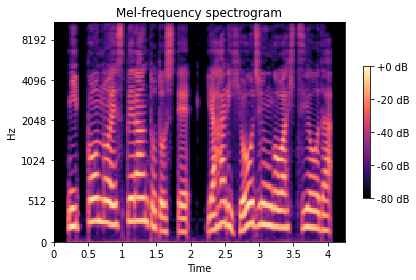

In [170]:
plot.plot_spectrogram(inputs['x'].detach().cpu().numpy().reshape(inputs['x'].shape[1:]))

In [285]:
max_ = 0
for idx in raw_specs:
    max_ = max(max_, raw_specs[idx].max())

In [286]:
max_

413.4232510032508

In [13]:
criterion(outputs, inputs['y']).item()

11.509880065917969

In [67]:
spec = torch.Tensor(spec.T)
new_spec = model(spec, train=False)

In [69]:
train_dataset = SpecDataset(raw_specs)

In [71]:
train_dataset[1]['spec'].shape

torch.Size([93, 384])